In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('mnist_train.csv')
data

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.shape

(59999, 785)

In [4]:
X_train = data.iloc[:, 1:].values.T / 255.0     #(Normalize pixel values to [0, 1])
labels = data.iloc[:, 0].values # Convert labels to one-hot encoding

In [5]:
def one_hot(y, num_classes = 10):
    m = y.shape[0]
    one_hot_y = np.zeros((num_classes, m))
    one_hot_y[y, np.arange(m)] = 1
    return one_hot_y

In [6]:
Y_train = one_hot(labels)
Y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
def initialize_parameters(layer_dims):
    np.random.seed(42)
    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters[f"w{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return parameters

# We used He initialization for the weights as it is suitable for ReLU activation functions. It basically keeps the variance of the activations across layers similar, which helps in training deep networks.


In [8]:
# We are using a 3 layer neutral network (2 hidden layers) for the MNIST dataset.
# The first layer has 128 neurons, the second layer has 64 neurons, and the output layer has 10 neurons (one for each digit).
layer_dims = [784, 128, 64, 10]
parameters = initialize_parameters(layer_dims)

In [29]:
# This is just used to visualize the MNIST dataset (will be used later).
def show_prediction(X_data, Y_true, Y_pred, num_samples = 16):
    plt.figure(figsize = (10, 10))
    indices = np.random.choice(X_data.shape[1], num_samples, replace = False)

    for i, idx in enumerate(indices):
        image = X_data[:, idx].reshape(28, 28)
        true_label = np.argmax(Y_true[:, idx])
        predicted_label = np.argmax(Y_pred[:, idx])

        plt.subplot(4, 4, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.title(f"True: {true_label} | Pred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
# Activation function used in the hidden layers is ReLU (Rectified Linear Unit).
def relu(Z):
    return np.maximum(0, Z)

In [11]:
# Activation function used in the output layer is softmax, which is suitable for multi-class classification problems.
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis = 0, keepdims = True))  
    # subtracted with the maximum value in the vector from all elements prevent overflow
    return expZ / np.sum(expZ, axis = 0, keepdims = True)

# Tried using (but didn't work):
# def softmax(Z):
#     return np.exp(Z) / sum(np.exp(Z))

In [12]:
def forward_propagation(X, parameters):
    w1 = parameters["w1"]
    b1 = parameters["b1"]
    w2 = parameters["w2"]
    b2 = parameters["b2"]
    w3 = parameters["w3"]
    b3 = parameters["b3"]

    # Layer 1
    Z1 = np.dot(w1, X) + b1
    A1 = relu(Z1)

    # Layer 2
    Z2 = np.dot(w2, A1) + b2
    A2 = relu(Z2)

    # Output Layer
    Z3 = np.dot(w3, A2) + b3
    A3 = softmax(Z3)

    intermediate_values = {
        "Z1": Z1, "A1": A1,
        "Z2": Z2, "A2": A2,
        "Z3": Z3, "A3": A3
    }
# Dictionary to store intermediate values for debugging or analysis & for faster backpropagation, since we will need these values later and it's better to compute them once alone rather than recomputing them during backpropagation.
    return A3, intermediate_values

In [13]:
def compute_cost(A3, Y):
    m = Y.shape[1]  
# m is the number of examples
    cost = -np.sum(Y * np.log(A3 + 1e-8)) / m
    return cost

In [14]:
def relu_derivative(Z):
    return Z > 0  
# basically returns a boolean array that works like 1/0 when multiplied

In [15]:
def backward_propagation(X, Y, parameters, intermediate_values):
    m = X.shape[1]  # number of training examples

    # Extract values from parameters and stored intermediate values
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    w3 = parameters["w3"]
    A1 = intermediate_values["A1"]
    A2 = intermediate_values["A2"]
    A3 = intermediate_values["A3"]
    Z1 = intermediate_values["Z1"]
    Z2 = intermediate_values["Z2"]
    Z3 = intermediate_values["Z3"]

    # Layer 3: Output layer gradients (Softmax + Cross-Entropy)
    dZ3 = A3 - Y
    dw3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis = 1, keepdims = True)

    # Layer 2 (ReLU)
    # Backpropagation through the second hidden layer
    dA2 = np.dot(w3.T, dZ3)
    dZ2 = dA2 * relu_derivative(Z2)
    dw2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)

    # Layer 1 (ReLU)
    # Backpropagation through the first hidden layer
    dA1 = np.dot(w2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dw1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)

    # This is used to update the parameters during gradient descent, by directly storing the gradients in a dictionary similar to how we stored the parameters.
    gradients = {
        "dw1": dw1, "db1": db1,
        "dw2": dw2, "db2": db2,
        "dw3": dw3, "db3": db3
    }

    return gradients

In [16]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["w1"] -= learning_rate * gradients["dw1"]
    parameters["b1"] -= learning_rate * gradients["db1"]
    parameters["w2"] -= learning_rate * gradients["dw2"]
    parameters["b2"] -= learning_rate * gradients["db2"]
    parameters["w3"] -= learning_rate * gradients["dw3"]
    parameters["b3"] -= learning_rate * gradients["db3"]
    return parameters

In [17]:
def predict(X, parameters):
    A3, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A3, axis = 0)
    return predictions

In [18]:
def compute_accuracy(predictions, labels):
    return np.mean(predictions == labels) * 100

In [19]:
def train_model(X, Y, parameters, num_epochs = 100, learning_rate = 0.01, print_every = 10):
    costs = []

    for i in range(num_epochs):
        A3, intermediate_values = forward_propagation(X, parameters)
        cost = compute_cost(A3, Y)
        gradients = backward_propagation(X, Y, parameters, intermediate_values)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if i % print_every == 0 or i == num_epochs - 1:
            predictions = np.argmax(A3, axis = 0)
            labels = np.argmax(Y, axis = 0)
            acc = compute_accuracy(predictions, labels)
            print(f"Epoch {i:04d} | Cost: {cost:.4f} | Accuracy: {acc:.2f}%")

        if i == num_epochs - 1:
            print("Training Complete!")
            print(f"Final Training Accuracy: {acc:.2f}%")

        costs.append(cost)

    return parameters, costs

In [20]:
trained_parameters, training_costs = train_model(X_train, Y_train, parameters, num_epochs = 3000, learning_rate = 0.1, print_every = 500)

Epoch 0000 | Cost: 2.3896 | Accuracy: 7.20%
Epoch 0500 | Cost: 0.2070 | Accuracy: 94.20%
Epoch 1000 | Cost: 0.1498 | Accuracy: 95.74%
Epoch 1500 | Cost: 0.1170 | Accuracy: 96.72%
Epoch 2000 | Cost: 0.0947 | Accuracy: 97.39%
Epoch 2500 | Cost: 0.0785 | Accuracy: 97.87%
Epoch 2999 | Cost: 0.0661 | Accuracy: 98.28%
Training Complete!
Final Training Accuracy: 98.28%


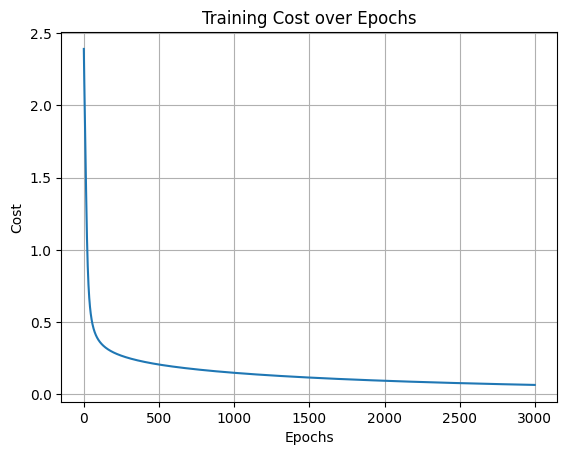

In [21]:
def plot_cost_curve(costs):
    plt.plot(costs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Training Cost over Epochs")
    plt.grid(True)
    plt.show()

plot_cost_curve(training_costs)

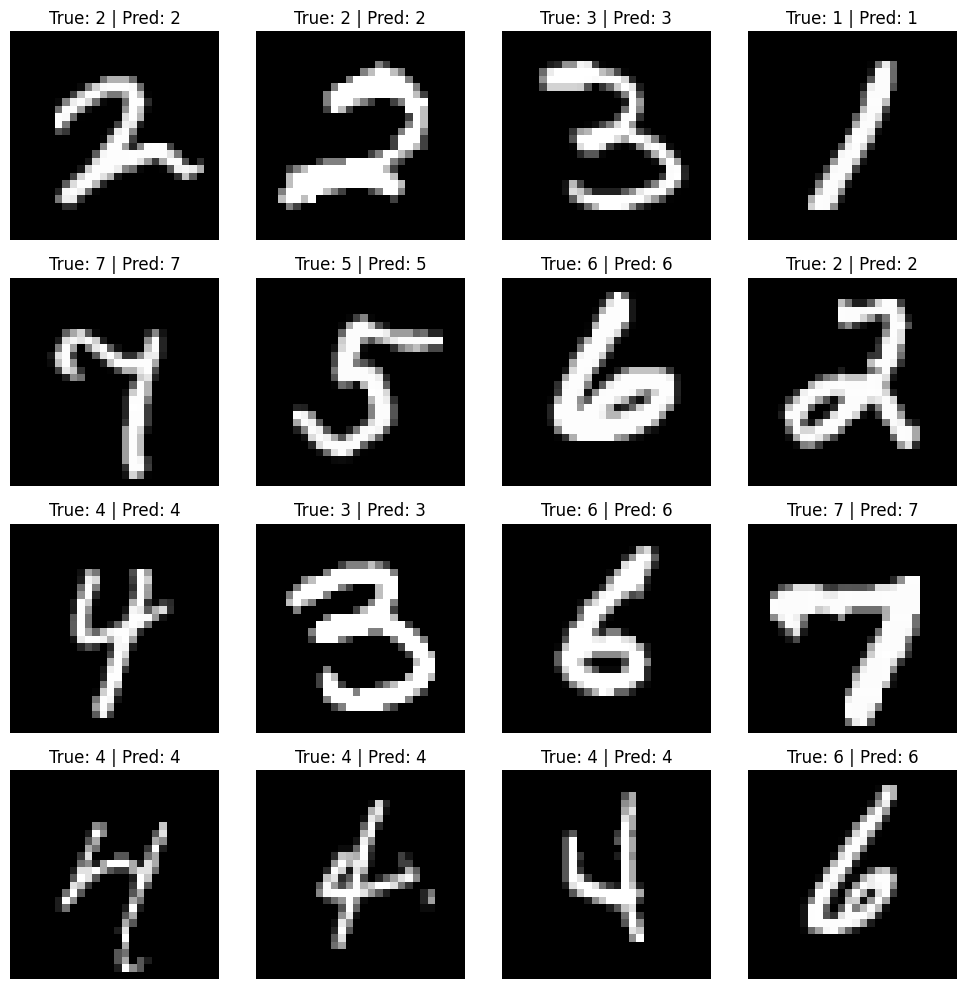

In [33]:
A3_train, _ = forward_propagation(X_train, trained_parameters)
show_prediction(X_data = X_train, Y_true = Y_train, Y_pred = A3_train)

In [23]:
# CHECKING THE ACCURACY ON TESTING DATA
test_df = pd.read_csv("mnist_test.csv")
X_test = test_df.iloc[:, 1:].values.T / 255.0
Y_test_unencoded = test_df.iloc[:, 0].values

# One-hot encode test labels
def one_hot(y, num_classes = 10):
    m = y.shape[0]
    one_hot_y = np.zeros((num_classes, m))
    one_hot_y[y, np.arange(m)] = 1
    return one_hot_y

Y_test = one_hot(Y_test_unencoded)

# Predict and evaluate
test_preds = predict(X_test, trained_parameters)
print("Test Accuracy:", compute_accuracy(test_preds, Y_test_unencoded))

Test Accuracy: 97.05970597059705


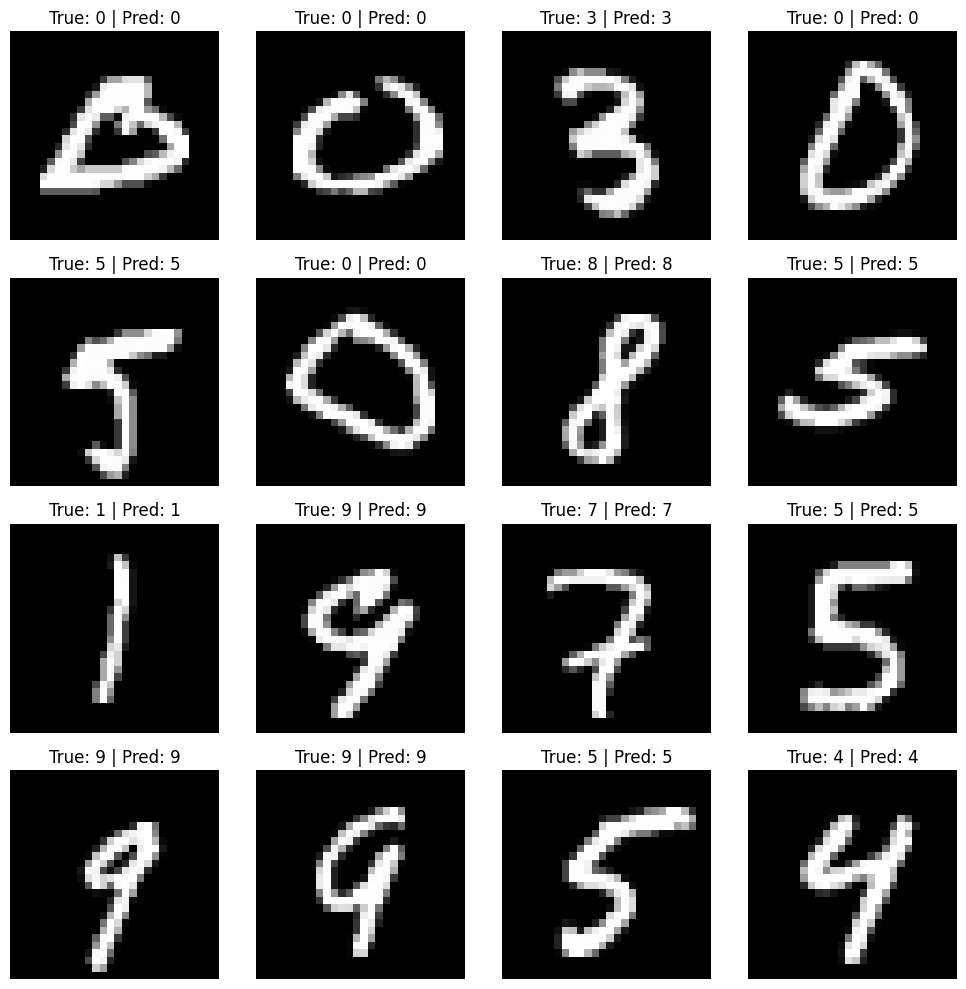

In [35]:
A3_test, _ = forward_propagation(X_test, trained_parameters)
show_prediction(X_data = X_test, Y_true = Y_test, Y_pred = A3_test)

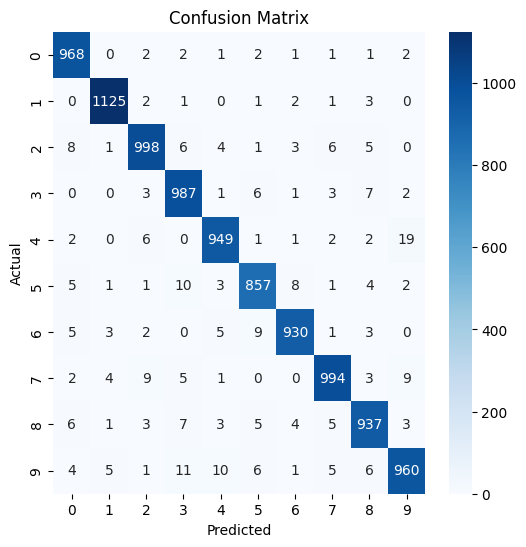

In [25]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
A3_test, _ = forward_propagation(X_test, trained_parameters)
y_pred = np.argmax(A3_test, axis = 0)
y_true = np.argmax(Y_test, axis = 0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = range(10), yticklabels = range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Classification Report
report_dict = classification_report(y_true, y_pred, output_dict = True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

print("Classification Report:\n")
display(report_df)

Classification Report:



,precision,recall,f1-score,support
0,0.9680,0.9878,0.9778,980.0000
1,0.9868,0.9912,0.9890,1135.0000
2,0.9718,0.9671,0.9694,1032.0000
3,0.9592,0.9772,0.9681,1010.0000
4,0.9713,0.9664,0.9689,982.0000
5,0.9651,0.9608,0.9629,892.0000
6,0.9779,0.9708,0.9743,958.0000
7,0.9755,0.9679,0.9717,1027.0000
8,0.9650,0.9620,0.9635,974.0000
9,0.9629,0.9514,0.9571,1009.0000
